# Create simulated dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pyem import star
import pandas as pd
import mrcfile

from simplecryoem.emfiles import load_data
from simplecryoem.forwardmodel import Slice
from simplecryoem.utils import (
    volume_fourier,
    mip_z,
    rescale_larger_grid,
    crop_fourier_volume,
    generate_uniform_orientations,
)

2024-10-11 00:59:07.578662: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
save_to_file = False

In [4]:
# Dirs and file locations

out_dir = "../../simplecryoem_output/out_dev_new/simulated_dataset/"

data_dir = "../../../../Relion5_SPA_tutorial/"
star_file = "Refine3D/job029/run_data.star"
refine3d_file = "../../../../Relion5_SPA_tutorial//Refine3D/job029/run_class001.mrc"

In [5]:
# Read the volume and the parameters from the star file

vol_r = mrcfile.open(refine3d_file).data

params, _ = load_data(data_dir, star_file, load_imgs=False, fourier=False)

ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]
nx = vol_r.shape[0]

print(f"vol_r.shape = {vol_r.shape}")

load_data: number of partcles: 4452
load_data: data loaded, time:  1.31 sec.
vol_r.shape = (256, 256, 256)


In [6]:
# Take FFT of volume

vol_f, grid, _ = volume_fourier(vol_r, pixel_size[0])

Text(0.5, 1.0, 'Fourier space (log of amplitude)')

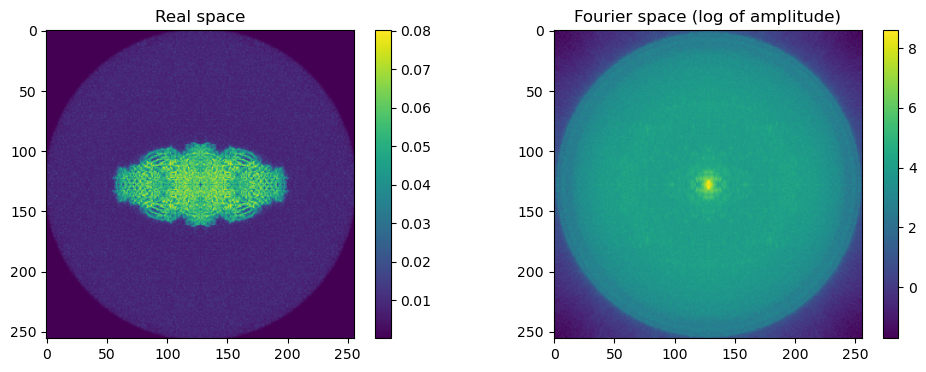

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mip_z(vol_r)
plt.colorbar()
plt.title("Real space")

plt.subplot(1, 2, 2)
mip_z(np.log(np.abs(np.fft.fftshift(vol_f))))
plt.colorbar()
plt.title("Fourier space (log of amplitude)")

In [8]:
# Save the vol
if save_to_file:
    with mrcfile.new(f"{out_dir}/vol2_{nx}.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_r.astype(np.float32))

#### Downsample the volume 

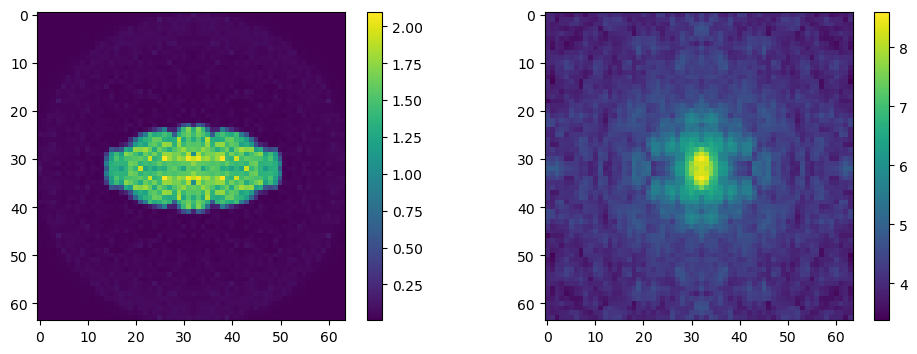

In [9]:
# First, crop to 64px

nx1 = 64

vol_fc, grid_c = crop_fourier_volume(vol_f, grid, nx1)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mip_z(vol_rc)
plt.colorbar()

plt.subplot(1, 2, 2)
mip_z(np.log(np.abs(np.fft.fftshift(vol_fc))))
plt.colorbar()

In [10]:
if save_to_file:
    with mrcfile.new(f"{out_dir}/vol2_{nx1}.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_rc.astype(np.float32))

### Create the slice object

In [11]:
interp_method = "tri"
mask = np.ones(vol_fc.shape)

slice_obj = Slice(grid_c, mask=mask, interp_method=interp_method)

### Some useful functions for processing images

In [12]:
def process_imgs(imgs_f, sigma_noise):
    """Given the FFT of the image, compute the real space images,
    add noise, and return everything."""

    N = imgs_f.shape[0]
    nx = int(np.sqrt(imgs_f.shape[1]))

    # IFFT
    imgs = np.array(
        [
            np.real(np.fft.fftshift(np.fft.ifft2(img_f.reshape([nx, nx]))))
            for img_f in imgs_f
        ]
    )

    # Add noise
    if sigma_noise > 0:
        sigma_noise = sigma_noise * np.max(np.abs(imgs))
        imgs_noisy = imgs + sigma_noise * np.random.randn(N, nx, nx)

    # FFT of noisy images too
    imgs_noisy_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs_noisy])

    return imgs, imgs_f, imgs_noisy, imgs_noisy_f


def write_star_and_mrcs(
    out_dir, mrcs_dir, imgs_filename, imgs, nx, pixel_size, angles, shifts, ctf_params
):
    """Write the images to an mrcs file and the parameters to a star file."""

    # First, save imgs to the mrcs file
    with mrcfile.new(
        f"{out_dir}/{mrcs_dir}/{imgs_filename}.mrcs", overwrite=True
    ) as mrc:
        mrc.set_data(imgs.astype(np.float32))

    # Load an existing star file and modify
    df = star.parse_star("comparisons/data/pyem.star", keep_index=False)

    newdf = pd.DataFrame()
    newdf["index"] = np.arange(N)

    newdf[star.Relion.ANGLEPSI] = np.rad2deg(angles[:, 0])
    newdf[star.Relion.ANGLETILT] = np.rad2deg(angles[:, 1])
    newdf[star.Relion.ANGLEROT] = np.rad2deg(angles[:, 2])

    newdf[star.Relion.ORIGINX] = 0
    newdf[star.Relion.ORIGINY] = 0
    newdf[star.Relion.ORIGINXANGST] = 0
    newdf[star.Relion.ORIGINYANGST] = 0

    newdf[star.Relion.DEFOCUSU] = ctf_params[:, 0]
    newdf[star.Relion.DEFOCUSV] = ctf_params[:, 1]
    newdf[star.Relion.DEFOCUSANGLE] = ctf_params[:, 2]
    newdf[star.Relion.PHASESHIFT] = ctf_params[:, 3]
    newdf[star.Relion.VOLTAGE] = ctf_params[:, 4]
    newdf[star.Relion.AC] = ctf_params[:, 5]
    newdf[star.Relion.CS] = ctf_params[:, 6]

    newdf[star.Relion.IMAGESIZE] = nx
    newdf[star.Relion.IMAGEPIXELSIZE] = pixel_size

    newdf[star.Relion.VOLTAGE] = df[star.Relion.VOLTAGE][0]
    newdf[star.Relion.OPTICSGROUP] = 1
    newdf[star.Relion.OPTICSGROUPNAME] = df[star.Relion.OPTICSGROUPNAME][0]
    newdf[star.Relion.CTFSCALEFACTOR] = df[star.Relion.CTFSCALEFACTOR][0]

    newdf[star.UCSF.IMAGE_ORIGINAL_PATH] = f"{imgs_filename}.mrcs"
    newdf[star.Relion.IMAGE_NAME] = [f"{i}@{imgs_filename}.mrcs" for i in np.arange(N)]

    # And finally write the star file
    star.write_star(f"{out_dir}/{mrcs_dir}/{imgs_filename}", newdf)

    return newdf


def compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy):
    norm_imgs = np.mean(np.real(np.sum(np.conj(imgs) * imgs, axis=(1, 2))))
    norm_imgs_noisy = np.mean(
        np.real(np.sum(np.conj(imgs_noisy) * imgs_noisy, axis=(1, 2)))
    )

    norm_imgs_f = np.mean(np.real(np.sum(np.conj(imgs_f) * imgs_f, axis=1)))
    norm_imgs_f_noisy = np.mean(
        np.real(np.sum(np.conj(imgs_f_noisy) * imgs_f_noisy, axis=(1, 2)))
    )

    # SNR
    snr = norm_imgs / norm_imgs_noisy
    snr_f = norm_imgs_f / norm_imgs_f_noisy
    print(f"SNR = {snr}")
    print(f"SNR_F = {snr_f}")

    return snr, snr_f

### Compute projections, save to file

In [13]:
mrcs_dir_clean = "relion_clean"
mrcs_dir_noisy = "relion_noisy"

imgs_filename = "particles"

In [14]:
N = 4000
sigma_noise = 0.3
shifts_simulate = np.zeros([N, 2])

# Select N sets of ctf_params at random
ctf_params_idx = np.random.permutation(ctf_params.shape[0])[:N]
ctf_params_simulate = ctf_params[ctf_params_idx]

# And generate uniform orientations
angles_simulate = generate_uniform_orientations(N)

In [15]:
# Take projections in Fourier - in batches so they fit on the GPU
N_batch = 1
angles_batch = np.array(np.array_split(angles_simulate, N_batch))
shifts_batch = np.array(np.array_split(shifts_simulate, N_batch))
ctf_params_batch = np.array(np.array_split(ctf_params_simulate, N_batch))

imgs_sim_f_batch = []
for bi in np.arange(N_batch):
    imgs_sim_f = slice_obj.slice_array(
        vol_fc, angles_batch[bi], shifts_batch[bi], ctf_params_batch[bi]
    )

    # Move to CPU
    imgs_sim_f_batch.append(np.array(imgs_sim_f))

imgs_sim_f = np.concatenate(imgs_sim_f_batch, axis=0)

In [16]:
print(imgs_sim_f_batch[0].shape)
print(imgs_sim_f.shape)

(4000, 4096)
(4000, 4096)


In [17]:
imgs_sim, imgs_sim_f, imgs_sim_noisy, imgs_sim_f_noisy = process_imgs(imgs_sim_f, sigma_noise)
_, _ = compute_snr(imgs_sim, imgs_sim_noisy, imgs_sim_f, imgs_sim_f_noisy)

SNR = 0.052653119133740316
SNR_F = 0.052793564122169935


In [18]:
if save_to_file:
    df_clean = write_star_and_mrcs(
        out_dir,
        mrcs_dir_clean,
        imgs_filename,
        imgs_sim,
        nx,
        pixel_size[0],
        angles_simulate,
        shifts_simulate,
        ctf_params_simulate,
    )
    df_noisy = write_star_and_mrcs(
        out_dir,
        mrcs_dir_noisy,
        imgs_filename,
        imgs_sim_noisy,
        nx,
        pixel_size[0],
        angles_simulate,
        shifts_simulate,
        ctf_params_simulate,
    )

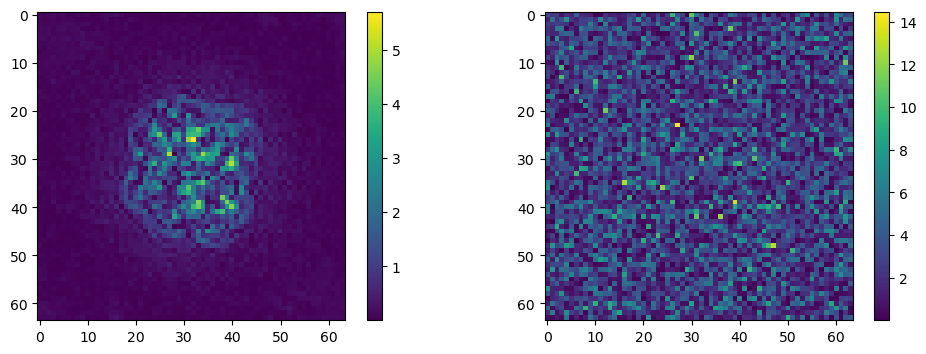

In [19]:
idx = 14
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow((np.abs(imgs_sim[idx].reshape([nx1, nx1]))))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow((np.abs(imgs_sim_noisy[idx].reshape([nx1, nx1]))))
plt.colorbar()

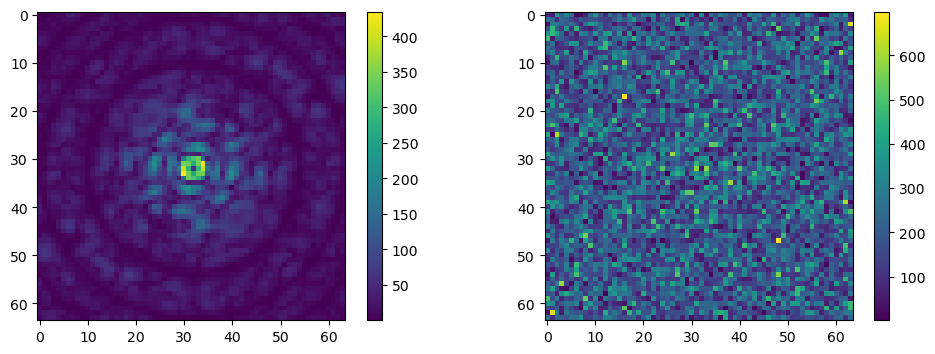

In [20]:
idx = 14
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.fft.fftshift(np.abs(imgs_sim_f[idx].reshape([nx1, nx1]))))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.fft.fftshift(np.abs(imgs_sim_f_noisy[idx].reshape([nx1, nx1]))))
plt.colorbar()